<a href="https://colab.research.google.com/github/vivan-doshi/Insurance_claims/blob/main/11_XGBoost/DSO530_ML_PROJECT_XGBOOST_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

In [3]:
# prompt: connect google colab

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/ML Project/cleaned_data_final.csv')
test_df = pd.read_csv('/content/drive/MyDrive/ML Project/cleaned_test_final.csv')

In [5]:
df['Loss_Cost'] = df['Loss_Cost'].fillna(0)
df['Historically_Adjusted_Loss_Cost'] = df['Historically_Adjusted_Loss_Cost'].fillna(0)

# STEP 4: Drop leakage and non-predictive columns
drop_cols = [
    'Unnamed: 0', 'ID',
    'Start_Date_Contract', 'Date_Last_Renewal', 'Date_Next_Renewal',
    'Date_Of_Birth', 'Date_Of_DL_Issuance',
    'Loss_Cost', 'Historically_Adjusted_Loss_Cost', 'Claim_Status',
    'Total_Cost_Claims_Current_Yr', 'Total_Number_Claims_Current_Yr',
    'Total_Number_Claims_Entire_Duration', 'Ratio_Claims_Total_Duration_Force'
]

In [6]:
# prompt: change nan values in Energy_Source to 'N'

df['Energy_Source'] = df['Energy_Source'].fillna('N')


In [7]:
X_raw = df.drop(columns=drop_cols)
y_lc = df['Loss_Cost']
y_halc = df['Historically_Adjusted_Loss_Cost']

In [8]:
X_encoded = pd.get_dummies(X_raw, drop_first=True)

In [9]:
y_lc_q = pd.qcut(y_lc, q=4, labels=False, duplicates='drop')
y_halc_q = pd.qcut(y_halc, q=4, labels=False, duplicates='drop')
combined_bins = y_lc_q * 4 + y_halc_q

In [10]:
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBRegressor

strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
feature_scores = pd.DataFrame(index=X_encoded.columns)

for fold, (train_idx, _) in enumerate(strat_kf.split(X_encoded, combined_bins)):
    X_fold_train = X_encoded.iloc[train_idx]
    y_fold = y_lc.iloc[train_idx]

    xgb = XGBRegressor(objective='reg:tweedie', n_estimators=300, random_state=42)
    xgb.fit(X_fold_train, y_fold)

    fold_importance = pd.Series(xgb.feature_importances_, index=X_encoded.columns, name=f'fold_{fold+1}')
    feature_scores = pd.concat([feature_scores, fold_importance], axis=1)

feature_scores['mean_importance'] = feature_scores.mean(axis=1)
sorted_features = feature_scores['mean_importance'].sort_values(ascending=False)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


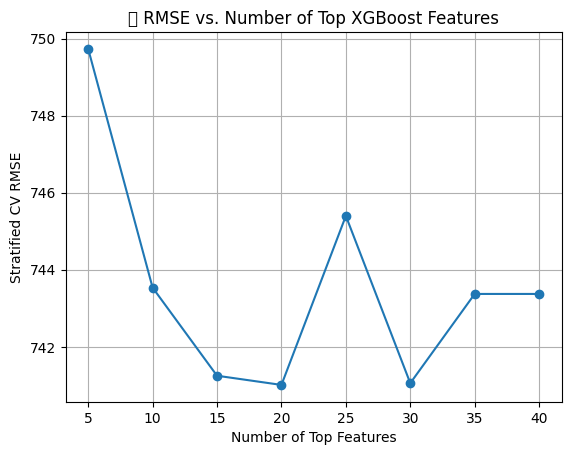

In [11]:
rmse_list = []
feature_counts = list(range(5, 41, 5))

for n in feature_counts:
    top_n_features = sorted_features.head(n).index.tolist()
    xgb = XGBRegressor(objective='reg:tweedie', n_estimators=300, random_state=42)

    scores = cross_val_score(
        xgb,
        X_encoded[top_n_features],
        y_lc,
        scoring='neg_root_mean_squared_error',
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_encoded[top_n_features], combined_bins),
        n_jobs=-1
    )
    rmse_list.append(-np.mean(scores))

plt.plot(feature_counts, rmse_list, marker='o')
plt.xlabel("Number of Top Features")
plt.ylabel("Stratified CV RMSE")
plt.title("📉 RMSE vs. Number of Top XGBoost Features")
plt.grid(True)
plt.show()

In [12]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.7 MB/s eta 0:00:00


In [27]:
sorted_features.head(20)

,mean_importance
Non_Continuation_Insurance_Flag,0.311365
Policies_Terminated_Non_Payment,0.061241
Half_Yearly_Payment_Method,0.060912
Contract_Duration,0.043994
Total_Policies_Entity,0.026744
Premium_Amt_Current_Yr,0.024913
Time_Since_Last_Renewal,0.024487
Car_Age_Cat_Recent,0.020131
Customer_Loyalty,0.018930
Ratio_Premium_Car_Value,0.018884


In [13]:
import optuna
from sklearn.metrics import mean_squared_error

top_features = sorted_features.head(20).index.tolist()
X_selected = X_encoded[top_features]

def objective_lc(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "tweedie_variance_power": trial.suggest_float("tweedie_variance_power", 1.1, 1.9),
    }

    strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in strat_kf.split(X_selected, combined_bins):
        X_tr, X_val = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
        y_tr, y_val = y_lc.iloc[train_idx], y_lc.iloc[val_idx]

        model = XGBRegressor(objective='reg:tweedie', random_state=42, **params)
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        scores.append(rmse)

    return np.mean(scores)

print("🔍 Tuning XGBoost for Loss Cost...")
study_lc = optuna.create_study(direction='minimize')
study_lc.optimize(objective_lc, n_trials=50, timeout=900)

print(f"✅ Best RMSE for LC: {study_lc.best_value:.2f}")
print("🎯 Best Params for LC:", study_lc.best_params)

[I 2025-04-26 03:05:21,168] A new study created in memory with name: no-name-9232dcb4-d9cb-4833-940a-d201845704ca


🔍 Tuning XGBoost for Loss Cost...


[I 2025-04-26 03:05:36,108] Trial 0 finished with value: 736.5220381833258 and parameters: {'n_estimators': 362, 'learning_rate': 0.009283436339612696, 'max_depth': 5, 'min_child_weight': 7.83196831447769, 'subsample': 0.7559348070345889, 'colsample_bytree': 0.7734920050025211, 'reg_alpha': 4.729417087837411, 'reg_lambda': 0.16029841704280512, 'tweedie_variance_power': 1.6929376377556598}. Best is trial 0 with value: 736.5220381833258.
[I 2025-04-26 03:06:07,795] Trial 1 finished with value: 734.6974225386314 and parameters: {'n_estimators': 416, 'learning_rate': 0.024199934248755446, 'max_depth': 5, 'min_child_weight': 2.587484304824777, 'subsample': 0.961219459739519, 'colsample_bytree': 0.9936551177028, 'reg_alpha': 3.877039891519991, 'reg_lambda': 4.5878647710825415, 'tweedie_variance_power': 1.895569148029748}. Best is trial 1 with value: 734.6974225386314.
[I 2025-04-26 03:06:22,532] Trial 2 finished with value: 733.7925795894187 and parameters: {'n_estimators': 217, 'learning_ra

✅ Best RMSE for LC: 732.87
🎯 Best Params for LC: {'n_estimators': 311, 'learning_rate': 0.016284185678443093, 'max_depth': 5, 'min_child_weight': 5.878897905048839, 'subsample': 0.9375409776977721, 'colsample_bytree': 0.7997815929967987, 'reg_alpha': 0.8850836334248451, 'reg_lambda': 0.41309681710572943, 'tweedie_variance_power': 1.3531149810698455}


In [14]:
print(top_features)

['Non_Continuation_Insurance_Flag', 'Policies_Terminated_Non_Payment', 'Half_Yearly_Payment_Method', 'Contract_Duration', 'Total_Policies_Entity', 'Premium_Amt_Current_Yr', 'Time_Since_Last_Renewal', 'Car_Age_Cat_Recent', 'Customer_Loyalty', 'Ratio_Premium_Car_Value', 'Vehicle_Wt_Kg', 'Vehicle_Doors', 'Market_Value_EOY19', 'Age_at_contract', 'Age_at_license', 'Power_Wt_Ratio', 'Days_Driving_At_Start_Date', 'Car_Age_Contract', 'Years_Driving', 'Yr_Vehicle_Registration']


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


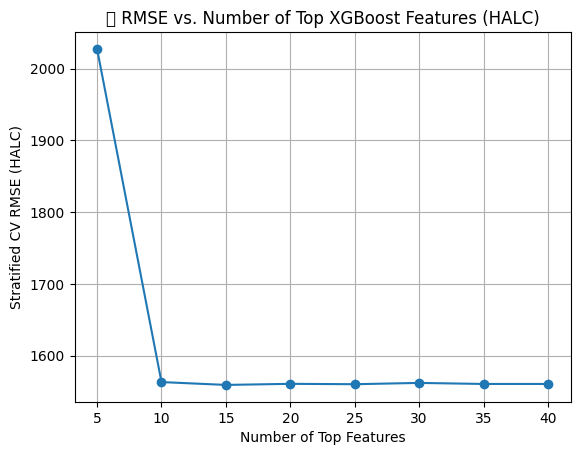

In [15]:
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Feature importance using stratified CV for HALC
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
feature_scores_halc = pd.DataFrame(index=X_encoded.columns)

for fold, (train_idx, _) in enumerate(strat_kf.split(X_encoded, combined_bins)):
    X_fold_train = X_encoded.iloc[train_idx]
    y_fold_halc = y_halc.iloc[train_idx]

    xgb = XGBRegressor(objective='reg:tweedie', n_estimators=300, random_state=42)
    xgb.fit(X_fold_train, y_fold_halc)

    fold_importance = pd.Series(xgb.feature_importances_, index=X_encoded.columns, name=f'fold_{fold+1}')
    feature_scores_halc = pd.concat([feature_scores_halc, fold_importance], axis=1)

feature_scores_halc['mean_importance'] = feature_scores_halc.mean(axis=1)
sorted_features_halc = feature_scores_halc['mean_importance'].sort_values(ascending=False)

# Step 2: RMSE vs. top-N features plot for HALC
rmse_list_halc = []
feature_counts = list(range(5, 41, 5))

for n in feature_counts:
    top_n_features = sorted_features_halc.head(n).index.tolist()
    xgb = XGBRegressor(objective='reg:tweedie', n_estimators=300, random_state=42)

    scores = cross_val_score(
        xgb,
        X_encoded[top_n_features],
        y_halc,
        scoring='neg_root_mean_squared_error',
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42).split(X_encoded[top_n_features], combined_bins),
        n_jobs=-1
    )
    rmse_list_halc.append(-np.mean(scores))

plt.plot(feature_counts, rmse_list_halc, marker='o')
plt.xlabel("Number of Top Features")
plt.ylabel("Stratified CV RMSE (HALC)")
plt.title("📉 RMSE vs. Number of Top XGBoost Features (HALC)")
plt.grid(True)
plt.show()

In [26]:
sorted_features_halc.head(15)

,mean_importance
Non_Continuation_Insurance_Flag,0.315804
Policies_Terminated_Non_Payment,0.065533
Contract_Duration,0.057213
Half_Yearly_Payment_Method,0.053843
Premium_Amt_Current_Yr,0.025315
Total_Policies_Entity,0.025101
Car_Age_Cat_Recent,0.022118
Customer_Loyalty,0.019559
Vehicle_Doors,0.018680
Age_at_contract,0.018656


In [16]:
top_features = sorted_features.head(15).index.tolist()
X_selected = X_encoded[top_features]
def objective_halc(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "tweedie_variance_power": trial.suggest_float("tweedie_variance_power", 1.1, 1.9),
    }

    strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in strat_kf.split(X_selected, combined_bins):
        X_tr, X_val = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
        y_tr, y_val = y_halc.iloc[train_idx], y_halc.iloc[val_idx]

        model = XGBRegressor(objective='reg:tweedie', random_state=42, **params)
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        scores.append(rmse)

    return np.mean(scores)

print("🔍 Tuning XGBoost for HALC...")
study_halc = optuna.create_study(direction='minimize')
study_halc.optimize(objective_halc, n_trials=50, timeout=900)

print(f"✅ Best RMSE for HALC: {study_halc.best_value:.2f}")
print("🎯 Best Params for HALC:", study_halc.best_params)

[I 2025-04-26 03:18:42,889] A new study created in memory with name: no-name-7af3f04d-932a-47be-a282-c84c472d3e6f


🔍 Tuning XGBoost for HALC...


[I 2025-04-26 03:18:48,777] Trial 0 finished with value: 1466.717800073845 and parameters: {'n_estimators': 226, 'learning_rate': 0.04287292892370325, 'max_depth': 5, 'min_child_weight': 1.3628441167786178, 'subsample': 0.8718243602650712, 'colsample_bytree': 0.7210307820984061, 'reg_alpha': 2.8834332908501525, 'reg_lambda': 2.69024834413445, 'tweedie_variance_power': 1.1578927121692861}. Best is trial 0 with value: 1466.717800073845.
[I 2025-04-26 03:18:56,753] Trial 1 finished with value: 1465.7336346426086 and parameters: {'n_estimators': 188, 'learning_rate': 0.04669992439619347, 'max_depth': 5, 'min_child_weight': 4.740055452217737, 'subsample': 0.9821207339758682, 'colsample_bytree': 0.7757198001812676, 'reg_alpha': 4.2203620651816625, 'reg_lambda': 1.9842181458894925, 'tweedie_variance_power': 1.6365856526441855}. Best is trial 1 with value: 1465.7336346426086.
[I 2025-04-26 03:19:03,012] Trial 2 finished with value: 1468.8364612156552 and parameters: {'n_estimators': 304, 'lear

✅ Best RMSE for HALC: 1464.96
🎯 Best Params for HALC: {'n_estimators': 446, 'learning_rate': 0.006608060127563637, 'max_depth': 5, 'min_child_weight': 1.0682791152505624, 'subsample': 0.8659915465157622, 'colsample_bytree': 0.745601066744246, 'reg_alpha': 4.258462857838453, 'reg_lambda': 0.5192582312470828, 'tweedie_variance_power': 1.213787244426902}


In [17]:
print(scores)

[ -849.21174071 -2296.56795941 -1535.80196299]


In [18]:
scores = []
for train_idx, val_idx in strat_kf.split(X_encoded, combined_bins):
  print(train_idx)
  print(val_idx)
  X_tr, X_val = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
  y_tr, y_val = y_halc.iloc[train_idx], y_halc.iloc[val_idx]

  model = XGBRegressor(objective='reg:tweedie', random_state=42, **study_halc.best_params)
  model.fit(X_tr, y_tr)
  preds = model.predict(X_val)
  rmse = np.sqrt(mean_squared_error(y_val, preds))
  scores.append(rmse)
  print(rmse)
scores

[    1     2     3 ... 37446 37448 37450]
[    0     4     5 ... 37442 37447 37449]
861.6821867135326
[    0     1     3 ... 37447 37449 37450]
[    2     6     9 ... 37419 37423 37448]
2892.215335830521
[    0     2     3 ... 37447 37448 37449]
[    1     7    18 ... 37444 37446 37450]
821.6594189579142
[    0     1     2 ... 37448 37449 37450]
[    3     8    12 ... 37433 37434 37436]
1093.818651119484
[    0     1     2 ... 37448 37449 37450]
[   10    11    21 ... 37424 37427 37445]
1655.430834740408


[np.float64(861.6821867135326),
 np.float64(2892.215335830521),
 np.float64(821.6594189579142),
 np.float64(1093.818651119484),
 np.float64(1655.430834740408)]

##CS Pred

In [19]:
y_claim = df['Claim_Status']

In [20]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import matplotlib.pyplot as plt

# Stratified K-Fold for Claim Status
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
feature_scores_claim = pd.DataFrame(index=X_encoded.columns)

for fold, (train_idx, _) in enumerate(strat_kf.split(X_encoded, y_claim)):
    X_fold_train = X_encoded.iloc[train_idx]
    y_fold_claim = y_claim.iloc[train_idx]

    xgbc = XGBClassifier(objective='binary:logistic', n_estimators=300, random_state=42, eval_metric='logloss')
    xgbc.fit(X_fold_train, y_fold_claim)

    fold_importance = pd.Series(xgbc.feature_importances_, index=X_encoded.columns, name=f'fold_{fold+1}')
    feature_scores_claim = pd.concat([feature_scores_claim, fold_importance], axis=1)

feature_scores_claim['mean_importance'] = feature_scores_claim.mean(axis=1)
sorted_features_claim = feature_scores_claim['mean_importance'].sort_values(ascending=False)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


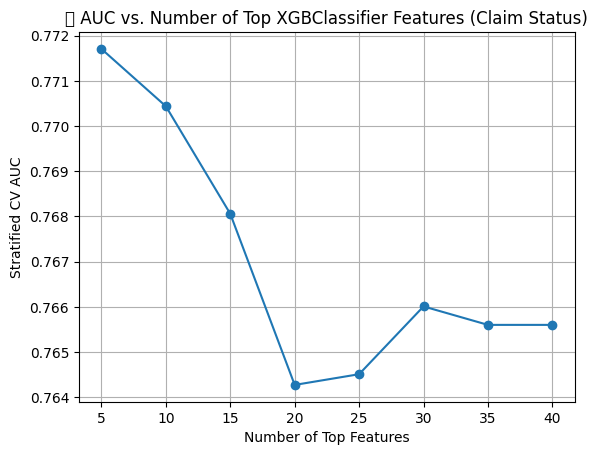

In [21]:
from sklearn.model_selection import cross_val_score

auc_list = []
feature_counts = list(range(5, 41, 5))

for n in feature_counts:
    top_n_features_claim = sorted_features_claim.head(n).index.tolist()
    xgbc = XGBClassifier(objective='binary:logistic', n_estimators=300, random_state=42, eval_metric='logloss')

    scores = cross_val_score(
        xgbc,
        X_encoded[top_n_features_claim],
        y_claim,
        scoring='roc_auc',
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1
    )
    auc_list.append(np.mean(scores))

plt.plot(feature_counts, auc_list, marker='o')
plt.xlabel("Number of Top Features")
plt.ylabel("Stratified CV AUC")
plt.title("📈 AUC vs. Number of Top XGBClassifier Features (Claim Status)")
plt.grid(True)
plt.show()

In [22]:
import optuna
from sklearn.metrics import roc_auc_score

top_features_claim = sorted_features_claim.head(20).index.tolist()
X_selected_claim = X_encoded[top_features_claim]

def objective_claim(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
    }

    strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in strat_kf.split(X_selected_claim, y_claim):
        X_tr, X_val = X_selected_claim.iloc[train_idx], X_selected_claim.iloc[val_idx]
        y_tr, y_val = y_claim.iloc[train_idx], y_claim.iloc[val_idx]

        model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42, **params)
        model.fit(X_tr, y_tr)
        preds = model.predict_proba(X_val)[:, 1]  # probability for positive class

        auc = roc_auc_score(y_val, preds)
        scores.append(auc)

    return -np.mean(scores)  # Negative because Optuna minimizes

print("\n🔍 Tuning XGBClassifier for Claim Status...")
study_claim = optuna.create_study(direction='minimize')
study_claim.optimize(objective_claim, n_trials=50, timeout=900)

print(f"✅ Best (negative AUC) for Claim Status: {study_claim.best_value:.4f}")
print("🎯 Best Parameters for Claim Status:", study_claim.best_params)

[I 2025-04-26 03:36:30,073] A new study created in memory with name: no-name-6191467c-b18d-4cbe-a426-9df47eafcaa4



🔍 Tuning XGBClassifier for Claim Status...


[I 2025-04-26 03:36:51,213] Trial 0 finished with value: -0.776524985709471 and parameters: {'n_estimators': 276, 'learning_rate': 0.18819265807299498, 'max_depth': 7, 'min_child_weight': 9.205681616280401, 'subsample': 0.7762240055802966, 'colsample_bytree': 0.9312309058419506, 'reg_alpha': 1.8501705560946076, 'reg_lambda': 1.074004491620768}. Best is trial 0 with value: -0.776524985709471.
[I 2025-04-26 03:37:00,047] Trial 1 finished with value: -0.8042123273070818 and parameters: {'n_estimators': 472, 'learning_rate': 0.11678139846787221, 'max_depth': 3, 'min_child_weight': 1.5279278864546586, 'subsample': 0.8836014277575238, 'colsample_bytree': 0.963865087881365, 'reg_alpha': 3.1746236947409545, 'reg_lambda': 3.053424345056419}. Best is trial 1 with value: -0.8042123273070818.
[I 2025-04-26 03:37:02,997] Trial 2 finished with value: -0.8040588664868601 and parameters: {'n_estimators': 115, 'learning_rate': 0.009651612957843685, 'max_depth': 6, 'min_child_weight': 2.5294499209572905

✅ Best (negative AUC) for Claim Status: -0.8091
🎯 Best Parameters for Claim Status: {'n_estimators': 499, 'learning_rate': 0.011929630568164026, 'max_depth': 6, 'min_child_weight': 9.451080329831608, 'subsample': 0.8583618783789972, 'colsample_bytree': 0.8590909785378026, 'reg_alpha': 2.255215820260597, 'reg_lambda': 3.2852135236977515}


In [28]:
sorted_features_claim.head(20)

,mean_importance
Non_Continuation_Insurance_Flag,0.245761
Contract_Duration,0.081343
Policies_Terminated_Non_Payment,0.066344
Time_Since_Last_Renewal,0.053786
Half_Yearly_Payment_Method,0.040297
Total_Policies_Entity,0.033438
Years_Associates,0.024836
Max_Policy_Simultaneous_Force,0.021519
Premium_Amt_Current_Yr,0.019599
Multiple_Drivers_Regular_Flag,0.018523


In [ ]:
# prompt: i want to git push this notebook

# Assuming you have a Git repository initialized in your Google Drive.
# Replace '/content/drive/MyDrive/your_repo' with the actual path to your repository.

!cd https://github.com/vivan-doshi/Insurance_claims/tree/main/012_Models && git add .
!cd https://github.com/vivan-doshi/Insurance_claims/tree/main/012_Models && git commit -m "Commit message"
!cd https://github.com/vivan-doshi/Insurance_claims/tree/main/012_Models && git push origin main
